### Importing The Required Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import uuid
import random
import numpy as np
from matplotlib import pyplot as plt

### Ignoring The Warning Messages

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Importing The Tensorflow's Functional API Instead of Sequential API

<ul>
    <li>
        A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
    </li>
    <li>
        <href><a>https://www.tensorflow.org/guide/keras/functional_api</a>
    </li>
    A Sequential model is not appropriate when:
    <ul>
        <li>
            Your model has multiple inputs or multiple outputs
        </li>
        <li>
            Any of your layers has multiple inputs or multiple outputs
        </li>
        <li>
            You need to do layer sharing
        </li>
        <li>
            You want non-linear topology (e.g. a residual connection, a multi-branch model)
        </li>
    </ul>
    <li>
    The Keras functional API is a way to create models that are more flexible than the keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.
    </li>
    <li>
The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.            
    </li>
</ul>


In [3]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### Setting Up The Path For Datasets - Positive, Negative, Anchor

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

### Creating the Directories - Positive, Negative, Anchor

In [19]:
try:
    os.makedirs(POS_PATH)
except Exception as e:
    print(e)

[Errno 17] File exists: 'data/positive'


In [20]:
try:
    os.makedirs(NEG_PATH)
except Exception as e:
    print(e)

[Errno 17] File exists: 'data/negative'


In [21]:
try:
    os.makedirs(ANC_PATH)
except Exception as e:
    print(e)

[Errno 17] File exists: 'data/anchor'


### Downloading the Labelled Faces In The Wild Dataset For Training
#### Labeled Faces in the Wild is a public benchmark for face verification, also known as pair matching.
<ul>
    <li>
        Welcome to Labeled Faces in the Wild, a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. More details can be found in the technical report below.
    </li>
    <li>
        There are now four different sets of LFW images including the original and three different types of "aligned" images. The aligned images include "funneled images" (ICCV 2007), LFW-a, which uses an unpublished method of alignment, and "deep funneled" images (NIPS 2012). Among these, LFW-a and the deep funneled images produce superior results for most face verification algorithms over the original images and over the funneled images (ICCV 2007).
    </li>
</ul>

In [8]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

### Transfering The Images From LFW To Negative Repository

In [22]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Capturing The Positive and Anchor Images

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    cv2.startWindowThread()
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = cv2.resize(frame, (640, 360))
    frame = frame[50:50+250, 200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Allign Your Face', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

2024-04-24 21:49:43.231 Python[3704:37757] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-04-24 21:49:44.665 Python[3704:37757] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


### Data Augmentation

In [11]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)


    return data

In [12]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

### Retreving The Images From The Directories

In [26]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [15]:
anchor.as_numpy_iterator().next()

b'data/anchor/1352a842-0299-11ef-86f4-1a289032f4a8.jpg'

### Preprocessing - Image Scaling & Resizing

In [23]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [17]:
img = preprocess('data/anchor/3427a216-0299-11ef-86f4-1a289032f4a8.jpg')

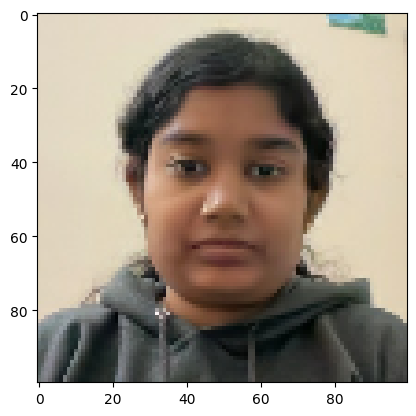

In [18]:
plt.imshow(img)

In [19]:
img.numpy().max()

0.98651963

### Dataset Creation - Labeling Data

In [27]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
exampple = samples.next()
exampple

(b'data/anchor/0d8d8094-0299-11ef-86f4-1a289032f4a8.jpg',
 b'data/positive/7eeb1b2a-0299-11ef-86f4-1a289032f4a8.jpg',
 1.0)

### Data Preprocessing

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [24]:
res = preprocess_twin(*exampple)

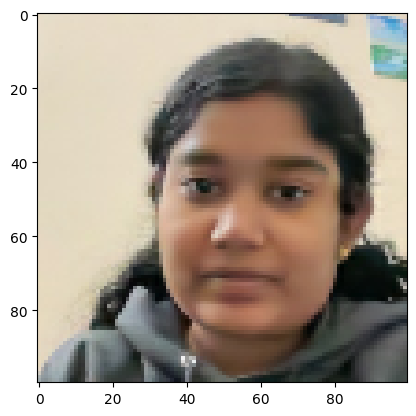

In [25]:
plt.imshow(res[0])

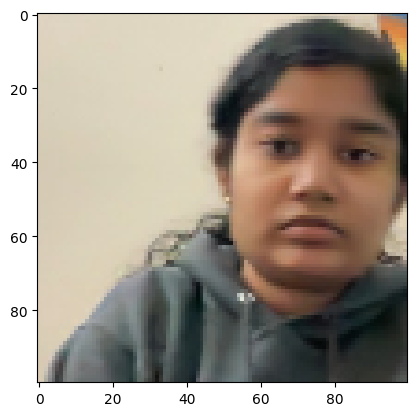

In [26]:
plt.imshow(res[1])

In [27]:
res[2]

1.0

### Train-Test Split

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [30]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Model Construction

In [5]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [6]:
embedding = make_embedding()

In [7]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Building Distance Layer

In [8]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
        

In [9]:
l1 = L1Dist()

### Building Siamese Neural Network

In [10]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(2, activation='softmax')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [11]:
siamese_model = make_siamese_model()

In [12]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

### Model Training

In [13]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [14]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [43]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [44]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [45]:
# train(train_data, EPOCHS = 50)

In [33]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 594ms/step


In [58]:
y_true

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [59]:
y_hat == y_true

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, Fals

### Evaluation Metrics

In [60]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [61]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.625

In [62]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 298ms/step
0.9632353 0.43666667


### Visualization Results

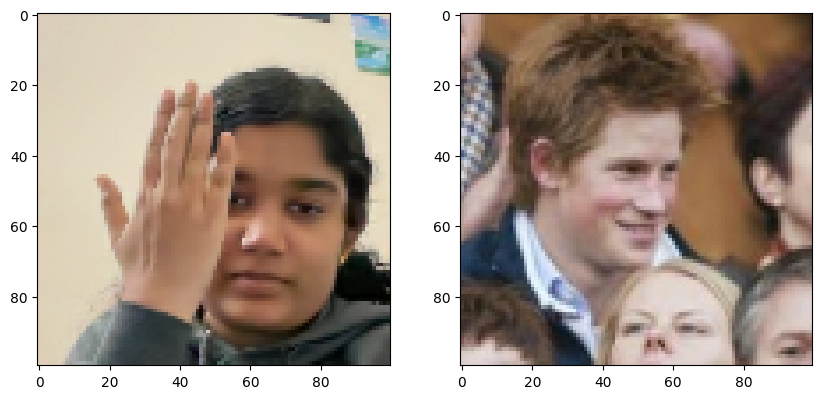

In [63]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

### Saving Weights

In [64]:
# Save weights
# siamese_model.save('siamesemodelv2.h5')

### Loading Weights From Colab Training

In [15]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodel-aug.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [34]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 542ms/step


array([[1.00916065e-01],
       [8.66923034e-02],
       [8.36647213e-01],
       [4.03103568e-02],
       [5.35935640e-01],
       [3.79217352e-04],
       [3.14546633e-05],
       [4.07799147e-02],
       [2.51197471e-05],
       [9.15264012e-04],
       [4.93363053e-01],
       [6.83616400e-01],
       [6.72386825e-01],
       [1.70962412e-05],
       [3.36111807e-05],
       [4.68116021e-03]], dtype=float32)

### Authentication

In [17]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [24]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
     # Cut down frame to 250x250px
    frame = cv2.resize(frame, (640, 360))
    frame = frame[50:50+250, 200:200+250, :]
    # frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 108ms/step
True
